# Next Best Action Experiment Analysis (Template)

Over the course of the next few weeks the Data Platforms team will be conducting a series of experiments (split-tests) to assess to efficacy of the Next Best Action (NBA) model; in-line with their allocated testing phase. These documents provide a breakdown of the results from these experiments.

The experiment is a A/B/n design and there are three variants (inc control):

    A. Control group: 25% will NOT see the newsletter pop up at all and no NBA (No change implemented/like the pop-up has never been implemented)

    B. Control group: 25% - Newsletter popup implemented and NBA not implemented

    C. New Test of NBA: 50% will see the newsletter popup based on NBA decision - newsletter popup implemented AND NBA implemented

The two primary metrics for this analysis will be:

    1. Page views per session per user
    2. Click-through rate
    
These reports are brokwn down into metrics and then the different comparisons between groups

# Page views per session per user

In [4]:
## Important necessary packages for analysis

import pandas as pd
import requests
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import theano.tensor as tt
from scipy.stats.mstats import mquantiles
import string
import random
import seaborn as sb
import warnings

In [5]:
warnings.filterwarnings("ignore")

In [6]:
## Import data

local = 'NBA_dummy_data_fh.csv'
df = pd.read_csv(local)
df.head()

,pvs_pb,model_version,User_Id
0,3.3,NBA,User_1
1,40.7,NBA,User_2
2,2.2,NBA,User_3
3,6.6,NBA,User_4
4,12.1,NBA,User_5


Weighting of groups:

In [7]:
df.groupby(['model_version']).count()

,pvs_pb,User_Id
model_version,,
Control_1,2211,2211
Control_2,2211,2211
NBA,2211,2211


Page views per browser by group:

In [8]:
df.groupby(['model_version']).mean()

,pvs_pb
model_version,
Control_1,7.361343
Control_2,6.590970
NBA,8.559701


## Visuals for Stakeholders

In [71]:
# Take random samples from each experimental condition in order to transform to normal distribution to plot distributions

results = [] # create an empty list into which I insert the sampled means
random_state = np.arange(0,1000) # random seeds for reproducibility


# Sample with replacement using 50% of the data; do this 1000 times and append the mean seeling time to the list ‘results’


for i in range(1000):
 sample = df.sample(frac=0.5, replace=True, random_state=random_state[i]).groupby(by='model_version')['pvs_pb'].mean()
 results.append(sample)
dist_samples = pd.DataFrame(results)
dist_samples.head(100)

model_version,Control_1,Control_2,NBA
pvs_pb,5.856029,7.423616,9.235354
pvs_pb,5.934461,5.588946,8.020628
pvs_pb,5.203417,5.693965,7.499215
pvs_pb,5.639715,7.741918,8.088988
pvs_pb,5.868858,6.894355,6.765098
...,...,...,...
pvs_pb,6.387208,4.421990,13.253117
pvs_pb,9.939031,5.554635,8.747527
pvs_pb,4.978756,4.086549,7.459913
pvs_pb,10.263336,5.411431,6.495190


model_version
Control_1    7.361343
Control_2    6.590970
NBA          8.559701
Name: pvs_pb, dtype: float64


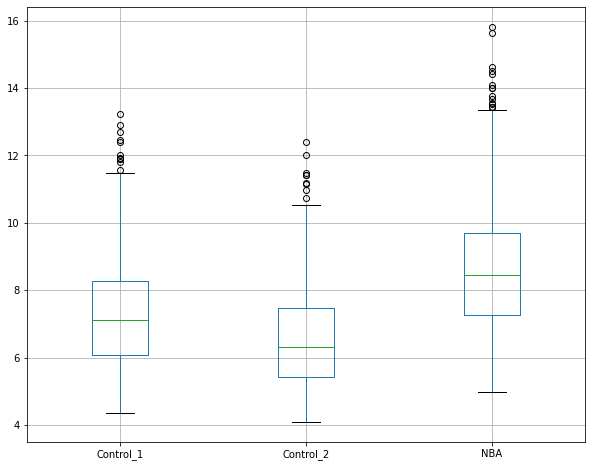

In [104]:
plt.figure(figsize=(10,8))
dist_samples.boxplot(column=['Control_1', 
                                       'Control_2',
                            'NBA'])

filtered = df.groupby(['model_version']).mean()
filtered = filtered['pvs_pb']
print(filtered)

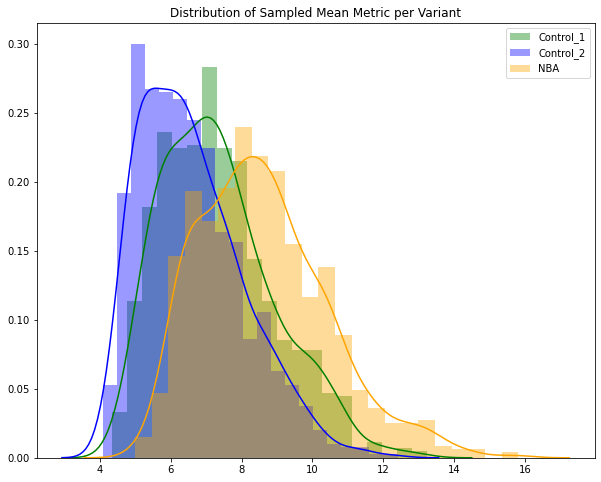

In [90]:
plt.figure(figsize=(10,8))
sb.distplot(dist_samples[['Control_1']], hist=True, color='green')
sb.distplot(dist_samples[['Control_2']], hist=True, color='blue')
sb.distplot(dist_samples[['NBA']], hist=True, color='orange')
plt.legend(labels=['Control_1','Control_2','NBA'])
plt.title("Distribution of Sampled Mean Metric per Variant")
plt.show()

## Statistical Comparisons

### Control group 1 vs NBA

In [119]:
## Random sample and create seperate frames for variants for analysis

Control_1 = df[(df['model_version'] == 'Control_1')]
NBA = df[(df['model_version'] == 'NBA')]

In [120]:
## Compute the pooled sample mean and pooled sample variance

pooled_mean = np.r_[Control_1.pvs_pb, NBA.pvs_pb].mean()
pooled_std = np.r_[Control_1.pvs_pb, NBA.pvs_pb].std()
variance = 2 * pooled_std

## Set prior distributions for the mean, variance, and the degree of freedom variables

with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)
    
## Fit the data into our model

with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed = Control_1.pvs_pb)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu = nu_minus_1+1, observed = NBA.pvs_pb)
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(25000, step=step)
    burned_trace_1 = trace_1[10000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 62 seconds.
The number of effective samples is smaller than 10% for some parameters.


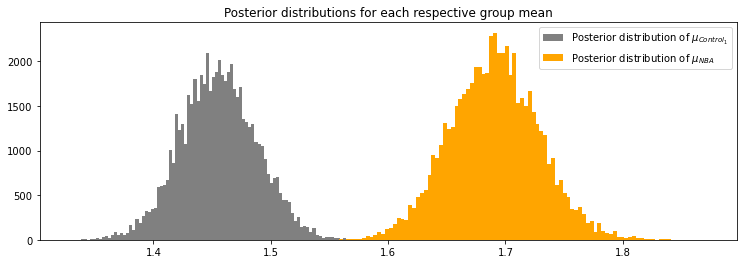

In [121]:
## Plot the posterior distributions for each respective group mean

figsize(12.5, 4)
control_1_mean = burned_trace_1['mu_A']
NBA_mean = burned_trace_1['mu_B']
plt.hist(control_mean, bins = 100, label=r'Posterior distribution of $\mu_{Control_1}$', color = 'grey')
plt.hist(variant_mean, bins = 100, label=r'Posterior distribution of $\mu_{NBA}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

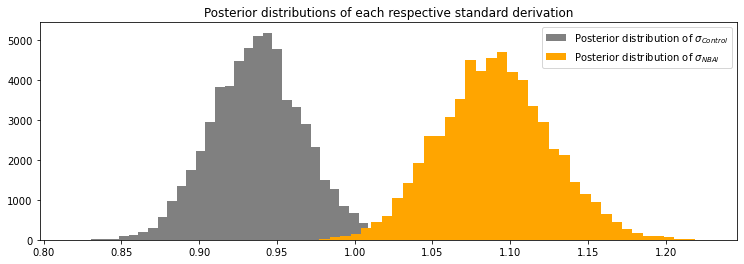

In [128]:
## Plot the posterior distributions for each respective group standard deviation

figsize(12.5, 4)
control__1_std = burned_trace_1['std_A']
NBA_std = burned_trace_1['std_B']
plt.hist(control__1_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control}$', color = 'grey')
plt.hist(NBA_std, bins = 40, label=r'Posterior distribution of $\sigma_{NBAl}$',  color = 'orange')
plt.title('Posterior distributions of each respective standard derivation')
plt.legend()
plt.show()

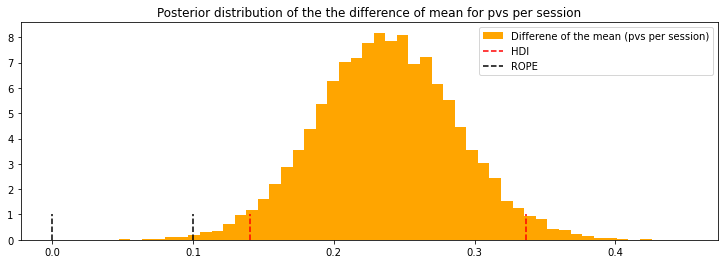

In [123]:
## Plot difference of means and stipulate ROPE value (practical significance)

figsize(12.5, 4)

difference = NBA_mean - control_1_mean # Difference of the means


hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference


rope = [0,0.1] #the ROPE region 


plt.hist(difference, bins=50, density=True, label='Differene of the mean (pvs per session)', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,1, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 1, linestyle='--', color='red')
plt.vlines(rope[0], 0, 1, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 1, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for pvs per session')
plt.legend(loc='upper right')
plt.show()

The probability that the variant performed 10% greater than the control is: 92.49%


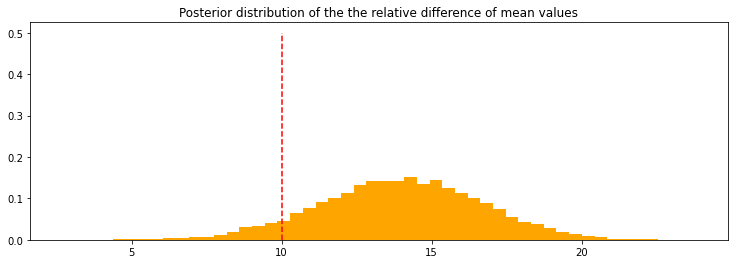

In [131]:
## Plot relative difference (%) of means and stipulate threshold of importance

figsize(12.5, 4)

rel_difference = 100 * (NBA_mean-control_1_mean)/NBA_mean # Relative difference of the means

prob = len(rel_difference[rel_difference > 10])/len(rel_difference)
plt.hist(rel_difference, bins = 50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(10, 0,0.5, linestyle='--', color='red', label='HDI')
print(f"The probability that the variant performed 10% greater than the control is: {round(prob*100,2)}%")
plt.show()

### Control group 2 vs NBA

In [125]:
## Random sample and create seperate frames for variants for analysis

Control_2 = df[(df['model_version'] == 'Control_1')]
NBA = df[(df['model_version'] == 'NBA')]

In [126]:
## Compute the pooled sample mean and pooled sample variance

pooled_mean = np.r_[Control_2.pvs_pb, NBA.pvs_pb].mean()
pooled_std = np.r_[Control_2.pvs_pb, NBA.pvs_pb].std()
variance = 2 * pooled_std

## Set prior distributions for the mean, variance, and the degree of freedom variables

with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)
    
## Fit the data into our model

with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed = Control_2.pvs_pb)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu = nu_minus_1+1, observed = NBA.pvs_pb)
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(25000, step=step)
    burned_trace_1 = trace_1[10000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 70 seconds.
The number of effective samples is smaller than 10% for some parameters.


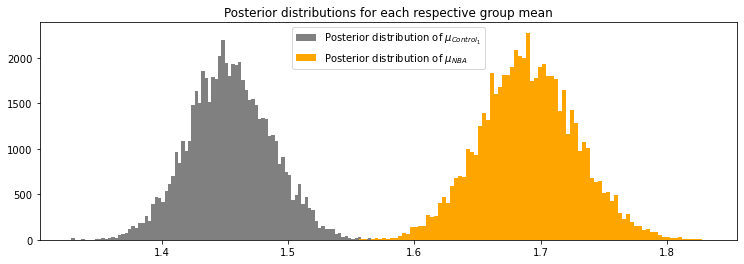

In [127]:
## Plot the posterior distributions for each respective group mean

figsize(12.5, 4)
control_2_mean = burned_trace_1['mu_A']
NBA_mean = burned_trace_1['mu_B']
plt.hist(control_2_mean, bins = 100, label=r'Posterior distribution of $\mu_{Control_1}$', color = 'grey')
plt.hist(NBA_mean, bins = 100, label=r'Posterior distribution of $\mu_{NBA}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

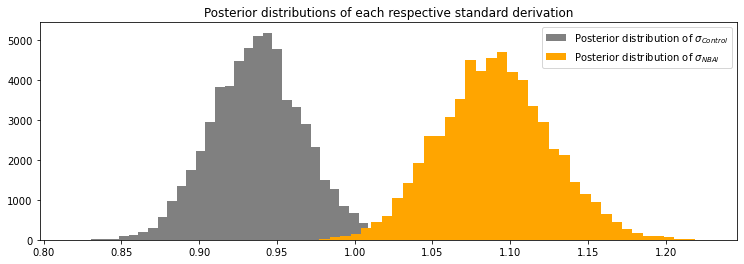

In [129]:
## Plot the posterior distributions for each respective group standard deviation

figsize(12.5, 4)
control__2_std = burned_trace_1['std_A']
NBA_std = burned_trace_1['std_B']
plt.hist(control__2_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control}$', color = 'grey')
plt.hist(NBA_std, bins = 40, label=r'Posterior distribution of $\sigma_{NBAl}$',  color = 'orange')
plt.title('Posterior distributions of each respective standard derivation')
plt.legend()
plt.show()

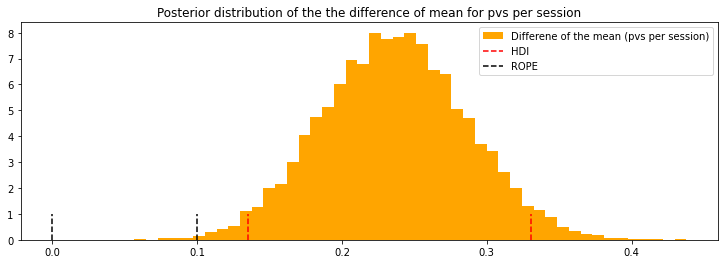

In [130]:
## Plot difference of means and stipulate ROPE value (practical significance)

figsize(12.5, 4)

difference = NBA_mean - control_2_mean # Difference of the means


hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference


rope = [0,0.1] #the ROPE region 


plt.hist(difference, bins=50, density=True, label='Differene of the mean (pvs per session)', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,1, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 1, linestyle='--', color='red')
plt.vlines(rope[0], 0, 1, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 1, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for pvs per session')
plt.legend(loc='upper right')
plt.show()

The probability that the variant performed 10% greater than the control is: 92.6%


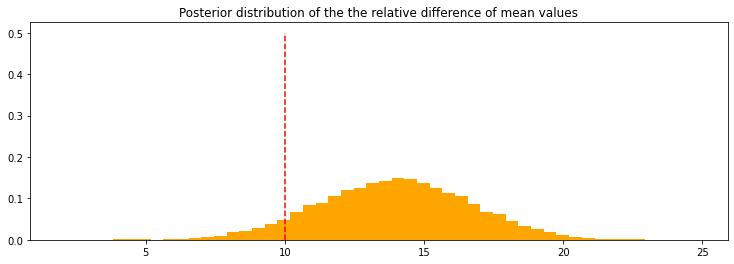

In [132]:
## Plot relative difference (%) of means and stipulate threshold of importance

figsize(12.5, 4)

rel_difference = 100 * (NBA_mean-control_2_mean)/NBA_mean # Relative difference of the means

prob = len(rel_difference[rel_difference > 10])/len(rel_difference)
plt.hist(rel_difference, bins = 50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(10, 0,0.5, linestyle='--', color='red', label='HDI')
print(f"The probability that the variant performed 10% greater than the control is: {round(prob*100,2)}%")
plt.show()

### Control group 1 vs Control group 2

In [9]:
## Random sample and create seperate frames for variants for analysis

Control_1 = df[(df['model_version'] == 'Control_1')]
Control_2 = df[(df['model_version'] == 'Control_2')]

In [10]:
## Compute the pooled sample mean and pooled sample variance

pooled_mean = np.r_[Control_1.pvs_pb, Control_2.pvs_pb].mean()
pooled_std = np.r_[Control_1.pvs_pb, Control_2.pvs_pb].std()
variance = 2 * pooled_std

## Set prior distributions for the mean, variance, and the degree of freedom variables

with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)
    
## Fit the data into our model

with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed = Control_1.pvs_pb)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu = nu_minus_1+1, observed = Control_2.pvs_pb)
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(25000, step=step)
    burned_trace_1 = trace_1[10000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 57 seconds.
The number of effective samples is smaller than 10% for some parameters.


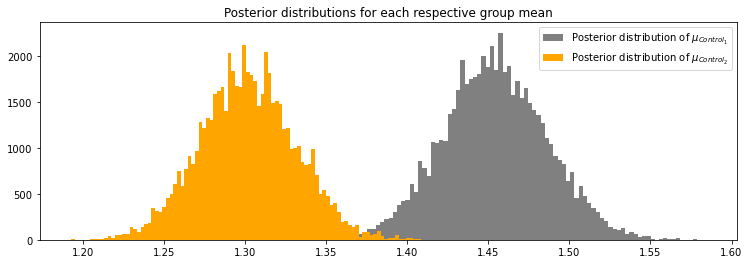

In [11]:
## Plot the posterior distributions for each respective group mean

figsize(12.5, 4)
control_1_mean = burned_trace_1['mu_A']
control_2_mean = burned_trace_1['mu_B']
plt.hist(control_1_mean, bins = 100, label=r'Posterior distribution of $\mu_{Control_1}$', color = 'grey')
plt.hist(control_2_mean, bins = 100, label=r'Posterior distribution of $\mu_{Control_2}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

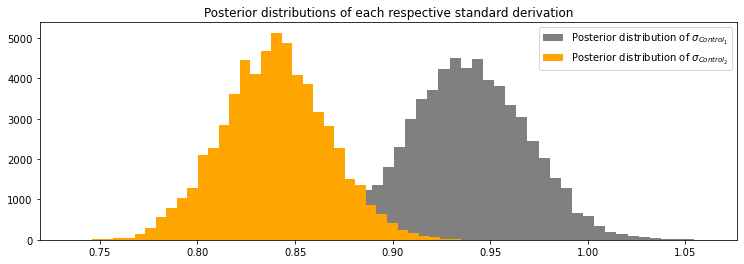

In [12]:
## Plot the posterior distributions for each respective group standard deviation

figsize(12.5, 4)
control__1_std = burned_trace_1['std_A']
control__2_std = burned_trace_1['std_B']
plt.hist(control__1_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control_1}$', color = 'grey')
plt.hist(control__2_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control_2}$',  color = 'orange')
plt.title('Posterior distributions of each respective standard derivation')
plt.legend()
plt.show()

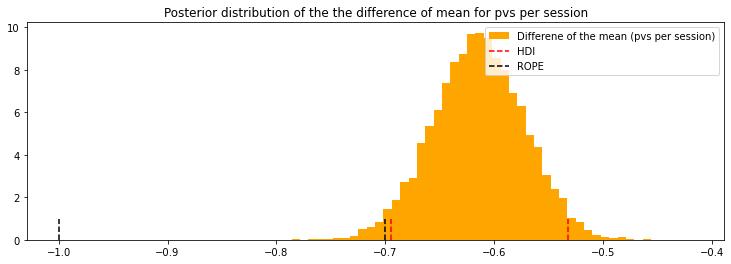

In [15]:
## Plot difference of means and stipulate ROPE value (practical significance)

figsize(12.5, 4)

difference = control__2_std - control_1_mean # Difference of the means


hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference


rope = [-1,-0.7] #the ROPE region 


plt.hist(difference, bins=50, density=True, label='Differene of the mean (pvs per session)', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,1, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 1, linestyle='--', color='red')
plt.vlines(rope[0], 0, 1, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 1, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for pvs per session')
plt.legend(loc='upper right')
plt.show()

The probability that the variant performed 1% greater than the control is: 0.0%


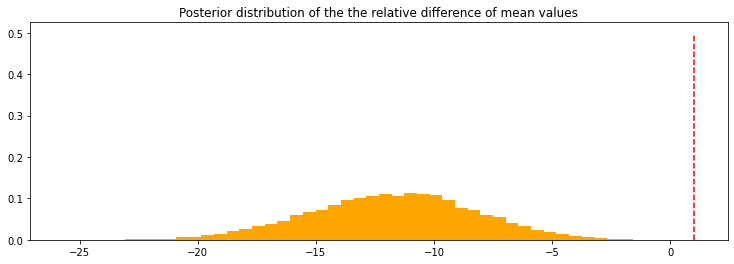

In [17]:
## Plot relative difference (%) of means and stipulate threshold of importance

figsize(12.5, 4)

rel_difference = 100 * (control_2_mean-control_1_mean)/control_2_mean # Relative difference of the means

prob = len(rel_difference[rel_difference > 1])/len(rel_difference)
plt.hist(rel_difference, bins = 50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(1, 0,0.5, linestyle='--', color='red', label='HDI')
print(f"The probability that the variant performed 1% greater than the control is: {round(prob*100,2)}%")
plt.show()

## Click-through rate

In [18]:
%matplotlib inline
from scipy.stats import beta
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False
import warnings
from numba import jit
import numpy as np
from math import lgamma

In [19]:
import warnings
warnings.filterwarnings("ignore")

### Control group 2 vs NBA

In [20]:
n_control = 164246

n_nba = 174904

In [21]:
e_control = 7883

e_nba = 10348

In [22]:
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [28]:
## Control ##

a_control = e_control + 1
b_control = n_control - (e_control + 1)
beta_control = beta(a_control, b_control)

## Variant ##

a_nba = e_nba + 1
b_nba = n_nba - (e_nba + 1)
beta_nba = beta(a_nba, b_nba)

## Calcuate the uplift

uplift = (beta_nba.mean() - beta_control.mean())/beta_control.mean()
print("The relative uplift/decrease between NBA and Control group is:",round(uplift*100,4),"%")

## Calculate the probability for test to be better than the control

prob = calc_prob_between(beta_nba, beta_control)
print("The probability that NBA beat Control is:",round(prob*100,3),"%")

The relative uplift/decrease between NBA and Control group is: 23.267 %
The probability that NBA beat Control is: 100.0 %


In [30]:
with pm.Model() as model:
    
    # Define priors (use the control pirior as the null hypothesis where no difference exists between variants)
    
    prior_control = pm.Beta('prior_control', alpha = e_control, beta = n_control - e_control)
    prior_nba = pm.Beta('prior_variant', alpha = e_nba, beta = n_nba - e_nba)

    # Define likelihood
    
    likelihood_control = pm.Binomial('like_control', n = 164246, p = prior_control, observed = e_control)
    likelihood_variant = pm.Binomial('like_variant', n = 174904, p = prior_nba, observed = e_nba)
    
    # Define metrics
    
    pm.Deterministic('absolute difference', prior_nba - prior_control)
    pm.Deterministic('relative difference', (prior_nba / prior_control) - 1)

    # Inference using MCMC
    trace = pm.sample(draws = 20000, step = pm.Metropolis(), start = pm.find_MAP(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [prior_variant]
>Metropolis: [prior_control]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.


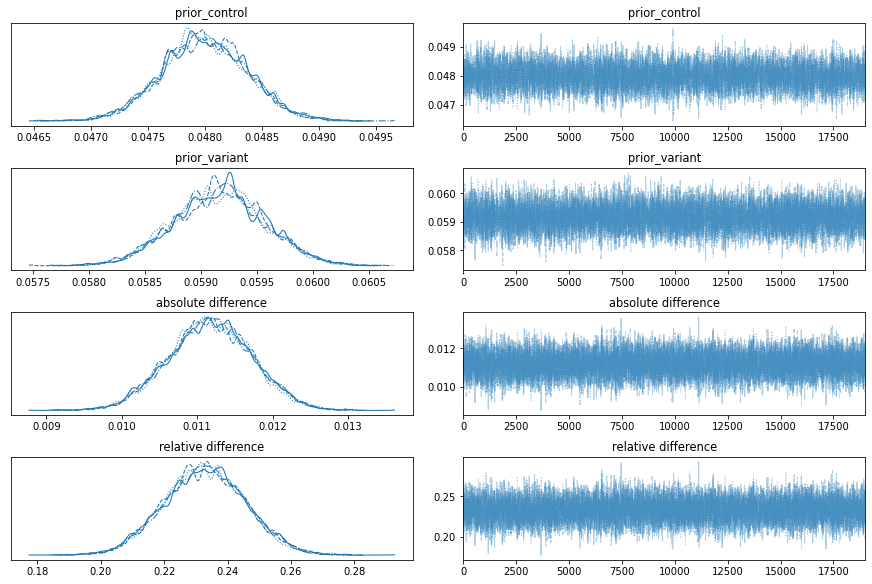

In [31]:
_ = pm.traceplot(trace[1000:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdac2dc9af0>,
      dtype=object)

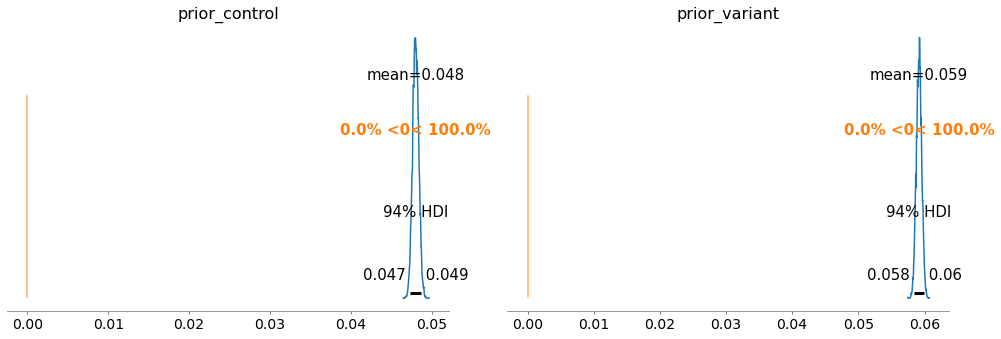

In [32]:
pm.plot_posterior(trace, var_names=['prior_control', 'prior_variant'], 
                      ref_val=0)

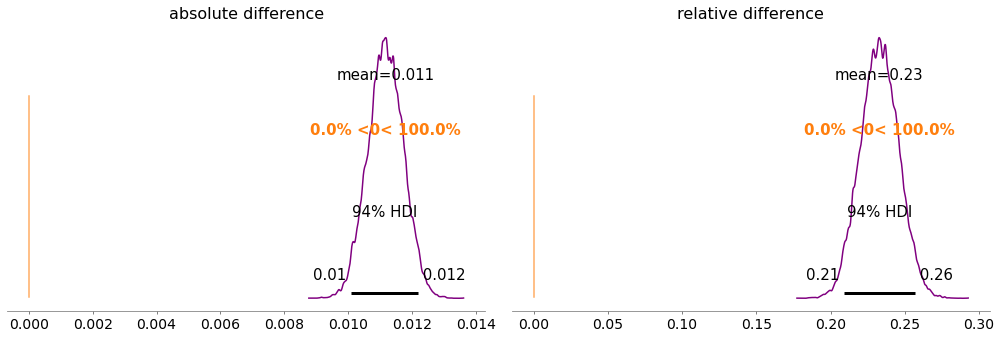

In [33]:
_ = pm.plot_posterior(trace[1000:], varnames=['absolute difference', 'relative difference'], 
                      ref_val=0, color='purple')